In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
cnn_std = tf.keras.models.load_model("E:\Research\pretrained\mnist\models\std\cnn_mnist_std.h5")
resnet_std = tf.keras.models.load_model("E:\Research\pretrained\mnist\models\std/resnet_mnist_std.h5")
densenet_std = tf.keras.models.load_model("E:\Research\pretrained\mnist\models\std\densenet_mnist_std.h5")

In [5]:
model_names = ['CNN', 'ResNet', 'DenseNet']

In [9]:
test_dataset = tf.data.Dataset.load('test_dataset')

BATCH_SIZE = 64

In [10]:
IMG_SIZE = 32

#Load and preprocess MNIST-M images
def load_image(img_path, label):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image/255.0
    label = tf.one_hot(label, 10)
    return image, label

#load the dataset
def load_dataset(data_dir):
    #initialize empty lists for storing image files and their corresponding labels
    images = []
    labels = []

    #iterate over each label directory (e.g. '0', '1', '2', ...)
    for label in sorted(os.listdir(data_dir)):
        label_dir = os.path.join(data_dir, label) #get the full path to the label directory

        #iterate over each image files in the current label directory
        for img in os.listdir(label_dir):
            images.append(os.path.join(label_dir, img))
            labels.append(int(label))

    images = tf.constant(images)
    labels = tf.constant(labels)

    dataset = tf.data.Dataset.from_tensor_slices((images, labels)) 
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(60000)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 

    return dataset

In [11]:
train_ood = "MNIST-M//training"
test_ood = "MNIST-M//testing"

train_ood = load_dataset(train_ood)
test_ood = load_dataset(test_ood)

ood_dataset = train_ood.concatenate(test_ood)

# Evaluation on OOD dataset

In [61]:
from collections import Counter

def analyze_class_distribution(dataset):
    class_counts = Counter()
    for _, label_batch in dataset:
        labels = np.argmax(label_batch.numpy(), axis=1)
        class_counts.update(labels)
    print(class_counts)

analyze_class_distribution(ood_dataset)

Counter({1: 7654, 7: 7072, 3: 6936, 2: 6786, 9: 6770, 0: 6703, 6: 6668, 8: 6637, 4: 6636, 5: 6138})


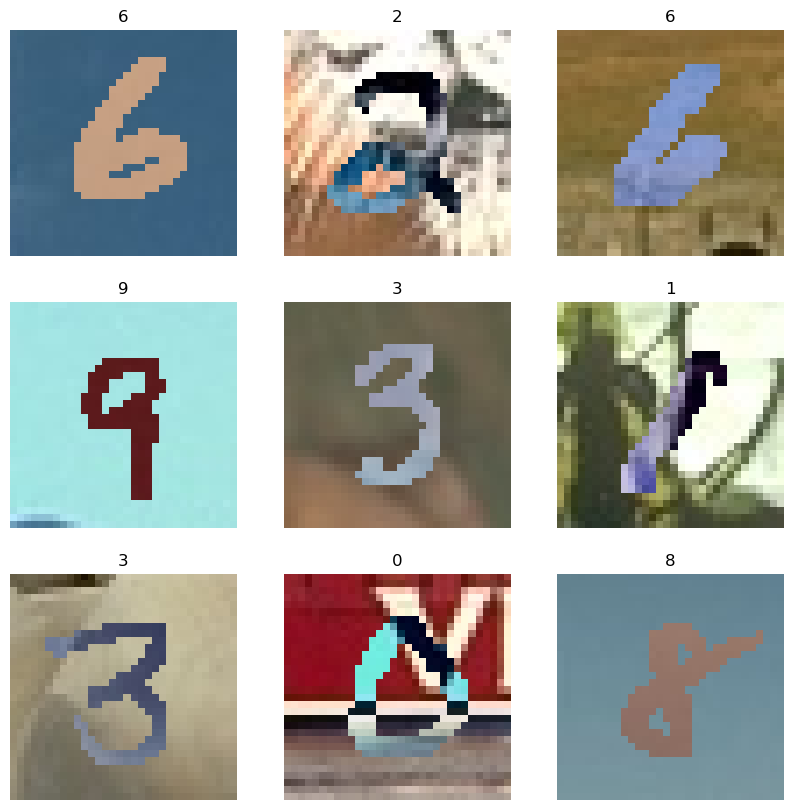

In [63]:
plt.figure(figsize=(10,10))

img_batch, label_batch = next(iter(ood_dataset))
# print(label_batch.numpy())
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(img_batch[i].numpy())
    plt.title(np.argmax(label_batch[i].numpy()))
    plt.axis("off")

plt.show()

Performance of Standard Models on Standard Test Set

In [64]:
_, std_test_acc_cnn_std = cnn_std.evaluate(test_dataset)
_, std_test_acc_resnet_std = resnet_std.evaluate(test_dataset)
_, std_test_densenet_std = densenet_std.evaluate(test_dataset)

print(f"CNN Std Test Accuracy: {std_test_acc_cnn_std:.4f}")
print(f"ResNet Std Test Accuracy: {std_test_acc_resnet_std:.4f}")
print(f"DenseNet Std Accuracy: {std_test_densenet_std:.4f}")

14/14 [==============================] - 3s 125ms/step - loss: 0.0521 - accuracy: 0.9877
CNN Std Test Accuracy: 0.9888
MLP Std Test Accuracy: 0.9665
MobileNet Std Test Accuracy: 0.9766
ResNet Std Test Accuracy: 0.9766
DenseNet Std Accuracy: 0.9877


In [66]:
_, ood_acc_cnn_std = cnn_std.evaluate(ood_dataset)
_, ood_resnet_std = resnet_std.evaluate(ood_dataset)
_, ood_densenet_std = densenet_std.evaluate(ood_dataset)

print(f"CNN Std OOD Accuracy: {ood_acc_cnn_std:.4f}")
print(f"ResNet Std OOD Accuracy: {ood_resnet_std:.4f}")
print(f"DenseNet OOD Accuracy: {ood_densenet_std:.4f}")

1063/1063 [==============================] - 210s 188ms/step - loss: 3.5342 - accuracy: 0.3355
CNN Std OOD Accuracy: 0.5272
MLP Std OOD Accuracy: 0.2408
MobileNet Std OOD Accuracy: 0.2798
ResNet Std OOD Accuracy: 0.3975
DenseNet OOD Accuracy: 0.3355


# Robustness calculation

In [ ]:
std_acc_std = [std_test_acc_cnn_std, std_test_acc_resnet_std, std_test_densenet_std]
ood_acc_std = [ood_acc_cnn_std, ood_resnet_std, ood_densenet_std]

In [68]:
robustness_scores_std = [ood / std for ood, std in zip(ood_acc_std, std_acc_std)]

for i, score in enumerate(robustness_scores_std):
    print(f"Robustness score for Std_{model_names[i]}: {score:.4f}")

Robustness score for Std_CNN: 0.5332
Robustness score for Std_MLP: 0.2492
Robustness score for Std_MobileNet: 0.2865
Robustness score for Std_ResNet: 0.4070
Robustness score for Std_DenseNet: 0.3397


# Appendix

In [39]:
_, oodTest_acc_cnn_std = cnn_std.evaluate(test_ood)
_, oodTest_resnet_std = resnet_std.evaluate(test_ood)
_, oodTest_densenet_std = densenet_std.evaluate(test_ood)

print(f"CNN Std OOD Accuracy: {oodTest_acc_cnn_std:.4f}")
print(f"ResNet Std OOD Accuracy: {oodTest_resnet_std:.4f}")
print(f"DenseNet OOD Accuracy: {oodTest_densenet_std:.4f}")

141/141 [==============================] - 16s 116ms/step - loss: 3.5446 - accuracy: 0.3308
CNN Std OOD Accuracy: 0.5239
MLP Std OOD Accuracy: 0.2399
MobileNet Std OOD Accuracy: 0.2802
ResNet Std OOD Accuracy: 0.3891
DenseNet OOD Accuracy: 0.3308


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


def get_predictions_and_labels(model, dataset):
    predictions = []
    true_labels = []

    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        predictions.extend(np.argmax(preds, axis=1))  # Get predicted class labels
        true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Get true class labels

    return np.array(predictions), np.array(true_labels)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return cm

cnn_pred_labels, cnn_true_labels = get_predictions_and_labels(cnn_std, ood_dataset)
resnet_pred_labels, resnet_true_labels = get_predictions_and_labels(resnet_std, ood_dataset)
densenet_pred_labels, densenet_true_labels = get_predictions_and_labels(densenet_std, ood_dataset)

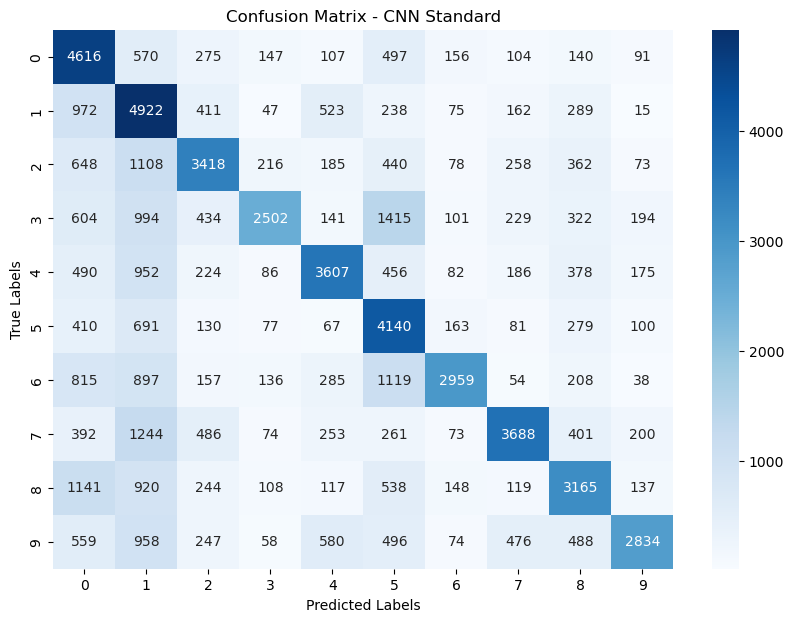

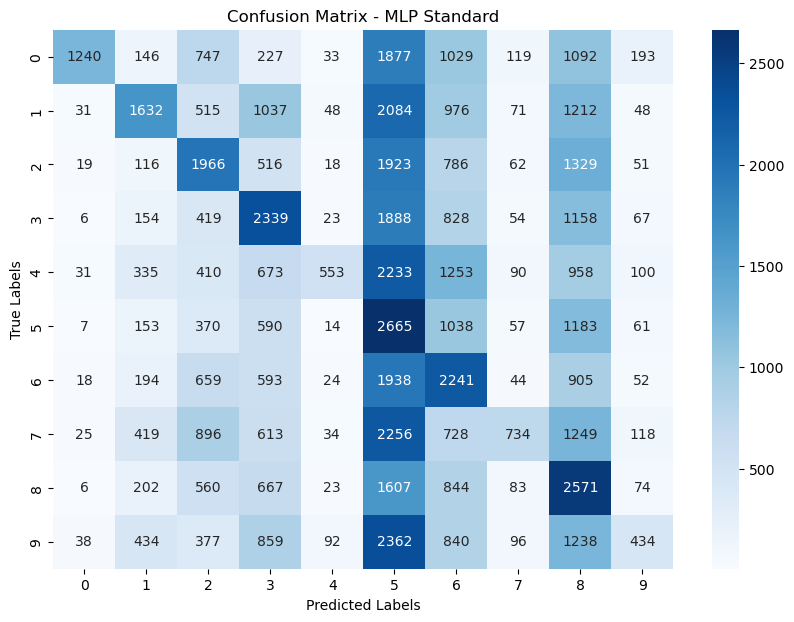

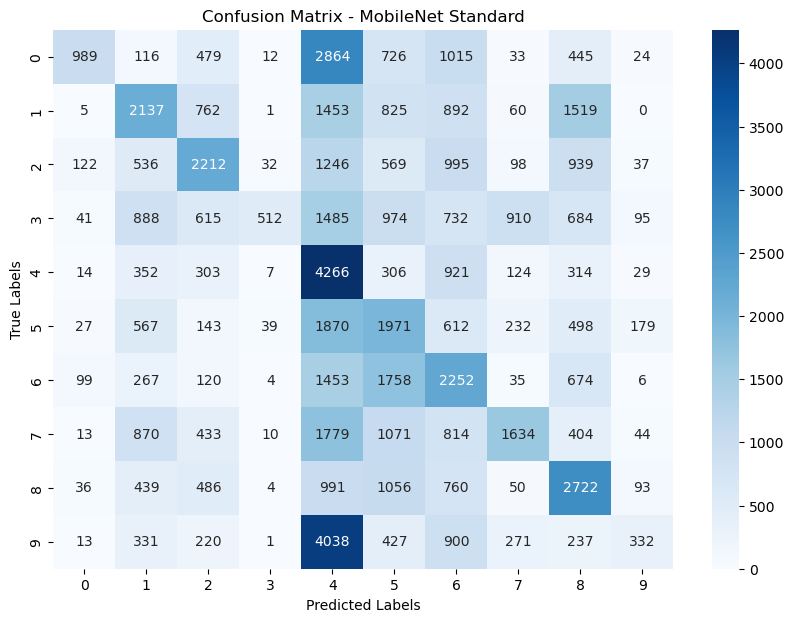

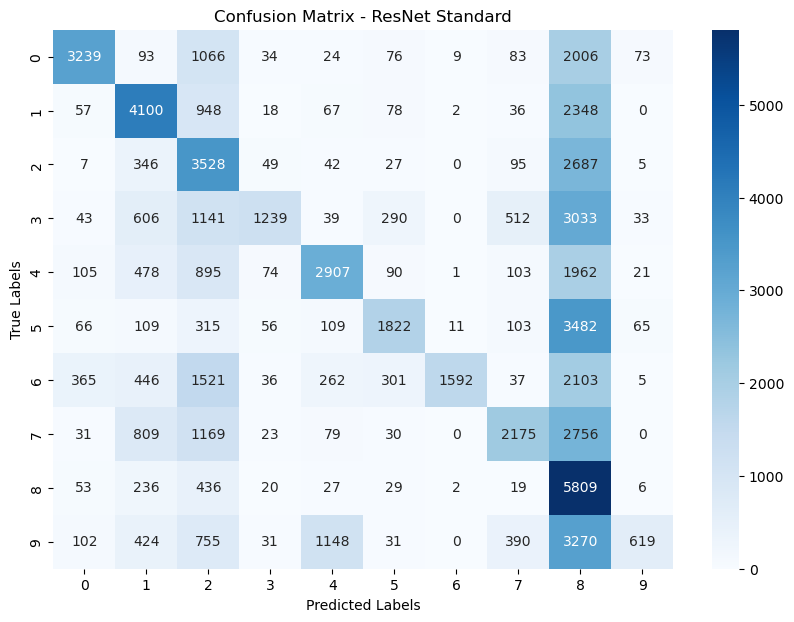

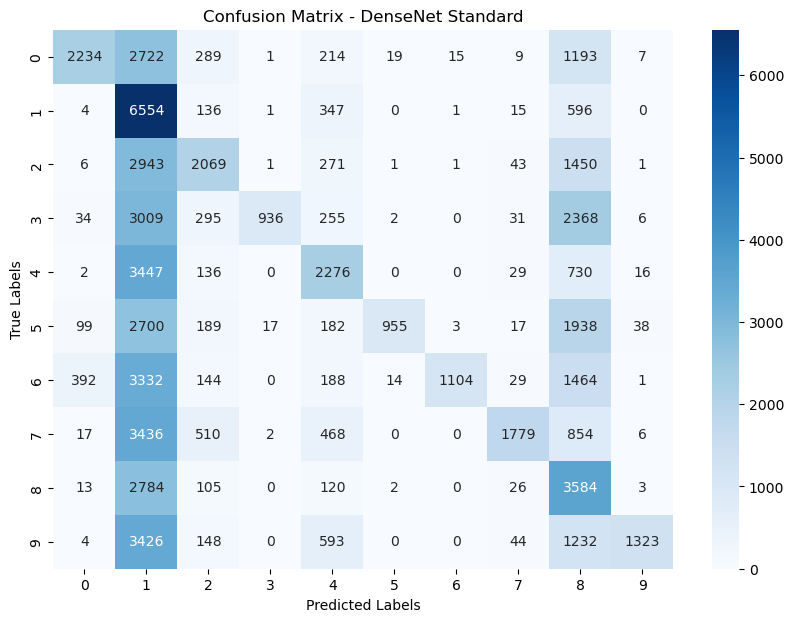

In [38]:
cnn_cm = plot_confusion_matrix(cnn_true_labels, cnn_pred_labels, 'CNN Standard')
resnet_cm = plot_confusion_matrix(resnet_true_labels, resnet_pred_labels, 'ResNet Standard')
densenet_cm= plot_confusion_matrix(densenet_true_labels, densenet_pred_labels, 'DenseNet Standard')

In [39]:
confusion_matrices = [cnn_cm,resnet_cm, densenet_cm]

errors_class_7 = []

for cm in confusion_matrices:
    row = cm[7] 
    errors = sum(row) - row[7]
    errors_class_7.append(errors)

std_deviation = np.std(errors_class_7)

print(f"Standard Deviation of Errors for Class 7: {std_deviation}")

Standard Deviation of Errors for Class 7: 965.9712211034033


In [40]:
max_error = max(errors_class_7)
min_error = min(errors_class_7)
print(f"Max error: {max_error}")
print(f"Min error: {min_error}")

normalized_errors = [(error - min_error) / (max_error - min_error) for error in errors_class_7]
scaled_std_deviation = np.std(normalized_errors)

print(f"Standard Deviation of Errors for Class 7: {std_deviation}")
print(f"Scaled Standard Deviation of Errors for Class 7: {scaled_std_deviation}")

Max error: 6338
Min error: 3384
Standard Deviation of Errors for Class 7: 965.9712211034033
Scaled Standard Deviation of Errors for Class 7: 0.327004475661274


In [34]:
def get_sample(class_index, dataset):
    image_list = []
    label_list = []

    for images, labels in dataset.unbatch():
        if np.argmax(labels, axis=0) == class_index: #labels are categorical
            image_list.append(images)
            label_list.append(labels)

    return image_list, label_list

In [35]:
img_list7, lbl_list7 = get_sample(class_index=7,
                           dataset=ood_dataset,)

In [36]:
print(len(img_list7))
print(len(lbl_list7))

7072
7072


(32, 32, 3) (10,) <class 'numpy.ndarray'>
Label : 7


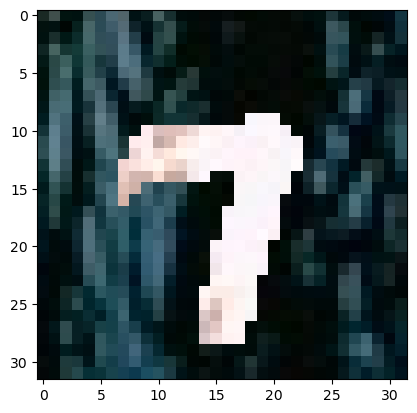

In [37]:
img = img_list7[0]
lbl = lbl_list7[0]

img = np.array(img)
print(img.shape, lbl.shape, type(img))
print("Label :" , np.argmax(lbl))
plt.imshow(img)

In [38]:
dataset_7 = tf.data.Dataset.from_tensor_slices((img_list7, lbl_list7)).batch(64)

In [47]:
_, cnn_std7 = cnn_std.evaluate(dataset_7)
_, resnet_std7 = resnet_std.evaluate(dataset_7)
_, densenet_std7 = densenet_std.evaluate(dataset_7)

111/111 [==============================] - 14s 125ms/step - loss: 3.4365 - accuracy: 0.2516
